In [37]:
import math ; pi=math.pi
import numpy as np
import matplotlib.pyplot as plt
import itertools
#%matplotlib widget
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
import time
import json
import imp
import os
np.warnings.filterwarnings('ignore')
import PySSC
import PySSC_AP
from classy import Class

# Define Gaussian Window
specifications : window centered on z=1, width=0.1, on range 0.1-1.9

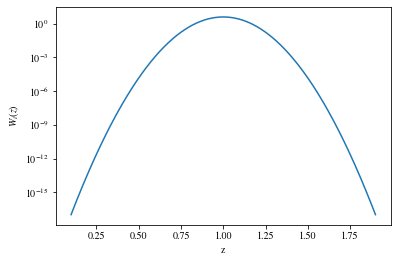

In [38]:
sigmaz    = 0.1
zcenter_G = [1]
nbins_G   = len(zcenter_G)
nz        = 400
windows_G = np.zeros((nbins_G,nz))
zmin = 0.1 ; zmax = 1.9
z_arr     = np.linspace(zmin,zmax,nz)
for i in range(nbins_G):
    windows_G[i,:] = np.exp(-(z_arr-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

# Plot window functions
fig,ax=plt.subplots(1,1)
for i in range(nbins_G):
    ax.semilogy(z_arr,windows_G[i,:])
ax.set_xlabel('z') ; ax.set_ylabel('$W_i(z)$')
fig.show()

In [39]:
# Same Gaussian but with more points to test convergence
nzbis           = 1000
windows_G_bis   = np.zeros((nbins_G,nzbis))
z_arr_bis       = np.linspace(zmin,zmax,nzbis)
for i in range(nbins_G):
    windows_G_bis[i,:] = np.exp(-(z_arr_bis-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

# Analytical formula
Implement the formula from the note https://www.overleaf.com/project/5d6551756c426848b8483888

for P(k)=1 (Mpc/h)^3 then

- in the limit $k_{min}=0$ and $k_{max}\rightarrow \infty$

$C_{\ell=0} = \frac{1}{(\int dV W^A W^B)(\int dV W^C W^D)}\int d V \ W^A_{i_z}(z) W^B_{j_z}(z)  \ W^C_{k_z}(z) W^D_{l_z}(z) D(z)^2 $
with everything in unit of Mpc/h

- with finite $k_{min}$ and $k_{max}$ it's a bit more complicated

$F(k,r_1,r_2) \equiv \frac{r_2 \sin(k r_1) \cos(k r_2) - r_1 \sin(k r_2) \cos(k r_1)}{r_1^3 r_2 - r_2^3 r_1}$

with the continuity point $F(k,r,r) = \frac{k}{2 r^2} - \frac{\sin(kr)\cos(kr)}{r^3}$

then $C_{\ell=0} = \frac{\frac{2}{\pi}}{(\int dV W^A W^B)(\int dV W^C W^D)}\int d V_1 d V_2 \ W^A_{i_z}(z_1) W^B_{j_z}(z_1) \ W^C_{k_z}(z_2) W^D_{l_z}(z_2) \times D(z_1) D(z_2) \left(F(k_{max},r_1,r_2)-F(k_{min},r_1,r_2)\right)$

- alternative formula with finite $k_{min}$ and $k_{max}$

$C_{\ell=0} = C_{\ell=0}^{-} - C_{\ell=0}^{+}$

$C_{\ell=0}^{+/-} = \frac{2}{\pi} \int \frac{d V_{12} \ W^A W^B  \ W^C W^D}{(\int W^A W^B)(\int W^C W^D)} \, D(z_1) D(z_2) [F_{+/-}(k_{max},r_1,r_2)-F_{+/-}(k_{min},r_1,r_2)]$

where

$F_-(k,r_1,r_2) =  \frac{k \ {sinc}(k (r_1-r_2))}{2 \, r_1 \, r_2} \\
F_+(k,r_1,r_2) =  \frac{k \ {sinc}(k (r_1+r_2))}{2 \, r_1 \, r_2}$

with $sinc(x)=sin(x)/x$, paying attention that numpy has a different convention $np.sinc(x)=sin(\pi x)/\pi x$

In [40]:
#Arrays used for all later integrals
precision = 10
cosmo = Class()
dico_for_CLASS = default_cosmo_params
dico_for_CLASS['output'] = 'mPk'
cosmo.set(dico_for_CLASS)
cosmo.compute()
h = cosmo.h() #for  conversions Mpc/h <-> Mpc
# Define arrays of r(z), k, P(k)...
zofr        = cosmo.z_of_r(z_arr)
comov_dist  = zofr[0]                                   #Comoving distance r(z) in Mpc
dcomov_dist = 1/zofr[1]                                 #Derivative dr/dz in Mpc
dV          = comov_dist**2 * dcomov_dist               #Comoving volume per solid angle in Mpc^3/sr
growth      = np.zeros(nz)                              #Growth factor
for iz in range(nz):
    growth[iz] = cosmo.scale_independent_growth_factor(z_arr[iz])
keq         = 0.02/h                                    #Equality matter radiation in 1/Mpc (more or less)
klogwidth   = 10                                        #Factor of width of the integration range.
kmin        = min(keq,1./comov_dist.max())/klogwidth
kmax        = max(keq,1./comov_dist.min())*klogwidth
nk          = 2**precision
logkmin     = np.log(kmin) ; logkmax   = np.log(kmax)
logk        = np.linspace(logkmin,logkmax,num=nk)
kk          = np.exp(logk)
#Normalisation int dV W_i^2
Normalisation = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand     = dV * windows_G[i,:]**2
    Normalisation[i] = integrate.simps(integrand,z_arr)

<h4>First integral</h4>

In [41]:
C_l0_0infty = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand     = dV * windows_G[i,:]**4 * growth**2
    C_l0_0infty[i] = integrate.simps(integrand,z_arr) / Normalisation[i]**2
print(C_l0_0infty/(4*pi))

[4.01641121e-12]


<h4>Second integral</h4>

In [42]:
def Fdummy(k,r1,r2):
    if r1 == r2:
        result = k/(2*r1**2) - (np.sin(k*r1)*np.cos(k*r1))/r1**3
    else:
        result = (r2*np.sin(k*r1)*np.cos(k*r2) - r1*np.sin(k*r2)*np.cos(k*r1))/(r1**3 * r2 - r2**3 * r1)
    return result
#Test
print(Fdummy(1,pi/2,pi),8./(pi**3*3))
print(Fdummy(1,pi,pi),1./(pi**2*2))

0.08600409182186532 0.08600409182186532
0.050660591821168895 0.05066059182116889


In [43]:
C_l0_kminmax = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand     = np.zeros((nz,nz))
    for j1 in range(nz):
        for j2 in range(nz):
            r1 = comov_dist[j1] ; r2 = comov_dist[j2]
            Ffactor = Fdummy(kmax,r1,r2) - Fdummy(kmin,r1,r2)
            integrand[j1,j2] = dV[j1] * dV[j2] * windows_G[i,j1]**2 * windows_G[i,j2]**2 * growth[j1] * growth[j1] * Ffactor
    #Manual 2D integral following https://stackoverflow.com/questions/20668689/integrating-2d-samples-on-a-rectangular-grid-using-scipy
    C_l0_kminmax[i] = integrate.simps([integrate.simps(integrand1D,z_arr) for integrand1D in integrand],z_arr) / Normalisation[i]**2
print(C_l0_kminmax/(4*pi))

[6.30941214e-12]


<h4>Third integral</h4>

In [44]:
print(np.sinc(0.5),2./pi) #np.sinc(x) = sinc(pi*x)
def Fdummy_plus(k,r1,r2):
    result = (k*np.sinc(k*(r1+r2)/pi))/(2.*r1*r2)
    return result
#Test
print(Fdummy_plus(1,pi/2,pi/2))
print(Fdummy_plus(1,pi/4,pi/4),16./pi**3)
def Fdummy_minus(k,r1,r2):
    result = (k*np.sinc(k*(r1-r2)/pi))/(2.*r1*r2)
    return result

0.6366197723675814 0.6366197723675814
7.89934768224168e-18
0.5160245509311919 0.5160245509311919


In [45]:
C_l0_kminmax_plus = np.zeros(nbins_G)
C_l0_kminmax_minus = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand_plus  = np.zeros((nz,nz))
    integrand_minus = np.zeros((nz,nz))
    for j1 in range(nz):
        for j2 in range(nz):
            r1 = comov_dist[j1] ; r2 = comov_dist[j2]
            Ffactor_plus  = Fdummy_plus(kmax,r1,r2) - Fdummy_plus(kmin,r1,r2)
            Ffactor_minus = Fdummy_minus(kmax,r1,r2) - Fdummy_minus(kmin,r1,r2)
            prefactor     = dV[j1] * dV[j2] * windows_G[i,j1]**2 * windows_G[i,j2]**2 * growth[j1] * growth[j1]
            integrand_plus[j1,j2]  = prefactor * Ffactor_plus
            integrand_minus[j1,j2] = prefactor * Ffactor_minus
    C_l0_kminmax_plus[i]  = integrate.simps([integrate.simps(integrand1D,z_arr) for integrand1D in integrand_plus],z_arr) / Normalisation[i]**2
    C_l0_kminmax_minus[i] = integrate.simps([integrate.simps(integrand1D,z_arr) for integrand1D in integrand_minus],z_arr) / Normalisation[i]**2
print(C_l0_kminmax_plus/(4*pi),C_l0_kminmax_minus/(4*pi),(C_l0_kminmax_minus-C_l0_kminmax_plus)/(4*pi))

[-2.41418834e-14] [6.28475232e-12] [6.3088942e-12]


<h4>Test convergence of the analytical integrals</h4>

In [46]:
zofr_bis        = cosmo.z_of_r(z_arr_bis)
comov_dist_bis  = zofr_bis[0]
dcomov_dist_bis = 1/zofr_bis[1]
dV_bis          = comov_dist_bis**2 * dcomov_dist_bis
growth_bis      = np.zeros(nzbis)
for iz in range(nzbis):
    growth_bis[iz] = cosmo.scale_independent_growth_factor(z_arr_bis[iz])
Normalisation_bis = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand     = dV_bis * windows_G_bis[i,:]**2
    Normalisation_bis[i] = integrate.simps(integrand,z_arr_bis)

In [47]:
# First integral
C_l0_0infty_bis = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand     = dV_bis * windows_G_bis[i,:]**4 * growth_bis**2
    C_l0_0infty_bis[i] = integrate.simps(integrand,z_arr_bis) / Normalisation_bis[i]**2
print(C_l0_0infty_bis/(4*pi))

[4.01641121e-12]


In [48]:
# Second integral
# This takes a bit longer to compute
C_l0_kminmax_bis = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand     = np.zeros((nzbis,nzbis))
    for j1 in range(nzbis):
        for j2 in range(nzbis):
            r1 = comov_dist_bis[j1] ; r2 = comov_dist_bis[j2]
            Ffactor = Fdummy(kmax,r1,r2) - Fdummy(kmin,r1,r2)
            integrand[j1,j2] = dV_bis[j1] * dV_bis[j2] * windows_G_bis[i,j1]**2 * windows_G_bis[i,j2]**2 * growth_bis[j1] * growth_bis[j1] * Ffactor
    #Manual 2D integral following https://stackoverflow.com/questions/20668689/integrating-2d-samples-on-a-rectangular-grid-using-scipy
    C_l0_kminmax_bis[i] = integrate.simps([integrate.simps(integrand1D,z_arr_bis) for integrand1D in integrand],z_arr_bis) / Normalisation_bis[i]**2
print(C_l0_kminmax_bis/(4*pi))

[6.30906789e-12]


In [49]:
# Third integral
# This also takes a bit long
C_l0_kminmax_plus_bis = np.zeros(nbins_G)
C_l0_kminmax_minus_bis = np.zeros(nbins_G)
for i in range(nbins_G):
    integrand_plus  = np.zeros((nzbis,nzbis))
    integrand_minus = np.zeros((nzbis,nzbis))
    for j1 in range(nzbis):
        for j2 in range(nzbis):
            r1 = comov_dist_bis[j1] ; r2 = comov_dist_bis[j2]
            Ffactor_plus  = Fdummy_plus(kmax,r1,r2) - Fdummy_plus(kmin,r1,r2)
            Ffactor_minus = Fdummy_minus(kmax,r1,r2) - Fdummy_minus(kmin,r1,r2)
            prefactor     = dV_bis[j1] * dV_bis[j2] * windows_G_bis[i,j1]**2 * windows_G_bis[i,j2]**2 * growth_bis[j1] * growth_bis[j1]
            integrand_plus[j1,j2]  = prefactor * Ffactor_plus
            integrand_minus[j1,j2] = prefactor * Ffactor_minus
    C_l0_kminmax_plus_bis[i]  = integrate.simps([integrate.simps(integrand1D,z_arr_bis) for integrand1D in integrand_plus],z_arr_bis) / Normalisation_bis[i]**2
    C_l0_kminmax_minus_bis[i] = integrate.simps([integrate.simps(integrand1D,z_arr_bis) for integrand1D in integrand_minus],z_arr_bis) / Normalisation_bis[i]**2
print(C_l0_kminmax_plus_bis/(4*pi),C_l0_kminmax_minus_bis/(4*pi),(C_l0_kminmax_minus_bis-C_l0_kminmax_plus_bis)/(4*pi))

[-2.41418834e-14] [6.28475232e-12] [6.3088942e-12]


So analytical integrals are well converged

# PySSC results

In [50]:
# Define function which is PySSC's Sij but with P(k)= 1 Mpc^3
default_cosmo_params = {'omega_b':0.022,'omega_cdm':0.12,'H0':67.,'n_s':0.96,'sigma8':0.81}
import math ; pi=math.pi
import numpy as np
import sys
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from classy import Class
def Sij_Pkone(z_arr, windows, cosmo_params=default_cosmo_params,precision=10,cosmo_Class=None):

    # Assert everything as the good type and shape, and find number of redshifts, bins etc
    zz  = np.asarray(z_arr)
    win = np.asarray(windows)
    
    assert zz.ndim==1, 'z_arr must be a 1-dimensional array'
    assert win.ndim==2, 'windows must be a 2-dimensional array'
    
    nz    = len(zz)
    nbins = win.shape[0]
    assert win.shape[1]==nz, 'windows must have shape (nbins,nz)'
    
    assert zz.min()>0, 'z_arr must have values > 0'
    
    # If the cosmology is not provided (in the same form as CLASS), run CLASS
    if cosmo_Class is None:
        cosmo = Class()
        dico_for_CLASS = cosmo_params
        dico_for_CLASS['output'] = 'mPk'
        cosmo.set(dico_for_CLASS)
        cosmo.compute()
    else:
        cosmo = cosmo_Class

    h = cosmo.h() #for  conversions Mpc/h <-> Mpc
    
    # Define arrays of r(z), k, P(k)...
    zofr        = cosmo.z_of_r(zz)
    comov_dist  = zofr[0]                                   #Comoving distance r(z) in Mpc
    dcomov_dist = 1/zofr[1]                                 #Derivative dr/dz in Mpc
    dV          = comov_dist**2 * dcomov_dist               #Comoving volume per solid angle in Mpc^3/sr
    growth      = np.zeros(nz)                              #Growth factor
    for iz in range(nz):
        growth[iz] = cosmo.scale_independent_growth_factor(zz[iz])
    
    # Compute normalisations
    Inorm       = np.zeros(nbins)
    for i1 in range(nbins):
        integrand = dV * windows[i1,:]**2
        Inorm[i1] = integrate.simps(integrand,zz)
    
    # Compute U(i,k), numerator of Sij (integral of Window**2 * matter )
    #Previous definition of k,P(k) arrays 
    keq         = 0.02/h                                          #Equality matter radiation in 1/Mpc (more or less)
    klogwidth   = 10                                              #Factor of width of the integration range. 10 seems ok
    kmin        = min(keq,1./comov_dist.max())/klogwidth
    kmax        = max(keq,1./comov_dist.min())*klogwidth
    nk          = 2**precision                                    #10 seems to be enough. Increase to test precision, reduce to speed up.
    kk          = np.linspace(kmin,kmax,num=nk)                   #linear grid on k
    #logkmin     = np.log(kmin) ; logkmax   = np.log(kmax)
    #logk        = np.linspace(logkmin,logkmax,num=nk)
    #kk          = np.exp(logk)                                     #logarithmic grid on k
    Pk          = np.zeros(nk)
    for ik in range(nk):
        #Pk[ik] = cosmo.pk(kk[ik],0.)                              #In Mpc^3
        Pk[ik] = 1.
    #Tweak to have P(k)= 1 (Mpc)^3
    #kk = (2*np.pi/(1000))*np.arange(1,1001)
    #Pk = np.ones(len(kk))
    #nk = len(kk)
    Uarr        = np.zeros((nbins,nk))
    for ibin in range(nbins):
        for ik in range(nk):
            kr            = kk[ik]*comov_dist
            integrand     = dV * windows[ibin,:]**2 * growth * np.sin(kr)/kr
            Uarr[ibin,ik] = integrate.simps(integrand,zz)
    
    # Compute Sij finally
    Cl_zero     = np.zeros((nbins,nbins))
    #For i<=j
    for ibin in range(nbins):
        U1 = Uarr[ibin,:]/Inorm[ibin]
        for jbin in range(ibin,nbins):
            U2 = Uarr[jbin,:]/Inorm[jbin]
            integrand = kk**2 * Pk * U1 * U2
            Cl_zero[ibin,jbin] = 2/pi * integrate.simps(integrand,kk)     #linear integration
            #Cl_zero[ibin,jbin] = 2/pi * integrate.simps(integrand*kk,logk) #log integration
    #Fill by symmetry   
    for ibin in range(nbins):
        for jbin in range(nbins):
            Cl_zero[ibin,jbin] = Cl_zero[min(ibin,jbin),max(ibin,jbin)]
    Sij = Cl_zero / (4*pi)
    
    return Sij

In [51]:
# Same but with logarithmic grid of k
def Sij_Pkone_logk(z_arr, windows, cosmo_params=default_cosmo_params,precision=10,cosmo_Class=None):

    # Assert everything as the good type and shape, and find number of redshifts, bins etc
    zz  = np.asarray(z_arr)
    win = np.asarray(windows)
    
    assert zz.ndim==1, 'z_arr must be a 1-dimensional array'
    assert win.ndim==2, 'windows must be a 2-dimensional array'
    
    nz    = len(zz)
    nbins = win.shape[0]
    assert win.shape[1]==nz, 'windows must have shape (nbins,nz)'
    
    assert zz.min()>0, 'z_arr must have values > 0'
    
    # If the cosmology is not provided (in the same form as CLASS), run CLASS
    if cosmo_Class is None:
        cosmo = Class()
        dico_for_CLASS = cosmo_params
        dico_for_CLASS['output'] = 'mPk'
        cosmo.set(dico_for_CLASS)
        cosmo.compute()
    else:
        cosmo = cosmo_Class

    h = cosmo.h() #for  conversions Mpc/h <-> Mpc
    
    # Define arrays of r(z), k, P(k)...
    zofr        = cosmo.z_of_r(zz)
    comov_dist  = zofr[0]                                   #Comoving distance r(z) in Mpc
    dcomov_dist = 1/zofr[1]                                 #Derivative dr/dz in Mpc
    dV          = comov_dist**2 * dcomov_dist               #Comoving volume per solid angle in Mpc^3/sr
    growth      = np.zeros(nz)                              #Growth factor
    for iz in range(nz):
        growth[iz] = cosmo.scale_independent_growth_factor(zz[iz])
    
    # Compute normalisations
    Inorm       = np.zeros(nbins)
    for i1 in range(nbins):
        integrand = dV * windows[i1,:]**2
        Inorm[i1] = integrate.simps(integrand,zz)
    
    # Compute U(i,k), numerator of Sij (integral of Window**2 * matter )
    #Previous definition of k,P(k) arrays 
    keq         = 0.02/h                                          #Equality matter radiation in 1/Mpc (more or less)
    klogwidth   = 10                                              #Factor of width of the integration range. 10 seems ok
    kmin        = min(keq,1./comov_dist.max())/klogwidth
    kmax        = max(keq,1./comov_dist.min())*klogwidth
    nk          = 2**precision                                    #10 seems to be enough. Increase to test precision, reduce to speed up.
    #kk          = np.linspace(kmin,kmax,num=nk)                   #linear grid on k
    logkmin     = np.log(kmin) ; logkmax   = np.log(kmax)
    logk        = np.linspace(logkmin,logkmax,num=nk)
    kk          = np.exp(logk)                                     #logarithmic grid on k
    Pk          = np.zeros(nk)
    for ik in range(nk):
        #Pk[ik] = cosmo.pk(kk[ik],0.)                              #In Mpc^3
        Pk[ik] = 1
    #Tweak to have P(k)= 1 (Mpc/h)^3
    #kk = (2*np.pi/(1000))*np.arange(1,1001)
    #logk = np.linspace(np.log(1),np.log(1001),num=1000)
    #kk = (2*np.pi/(1000))*np.exp(logk)
    #Pk = np.ones(len(kk))
    nk = len(kk)
    Uarr        = np.zeros((nbins,nk))
    for ibin in range(nbins):
        for ik in range(nk):
            kr            = kk[ik]*comov_dist
            integrand     = dV * windows[ibin,:]**2 * growth * np.sin(kr)/kr
            Uarr[ibin,ik] = integrate.simps(integrand,zz)
    
    # Compute Sij finally
    Cl_zero     = np.zeros((nbins,nbins))
    #For i<=j
    for ibin in range(nbins):
        U1 = Uarr[ibin,:]/Inorm[ibin]
        for jbin in range(ibin,nbins):
            U2 = Uarr[jbin,:]/Inorm[jbin]
            integrand = kk**2 * Pk * U1 * U2
            #Cl_zero[ibin,jbin] = 2/pi * integrate.simps(integrand,kk)     #linear integration
            Cl_zero[ibin,jbin] = 2/pi * integrate.simps(integrand*kk,logk) #log integration
    #Fill by symmetry   
    for ibin in range(nbins):
        for jbin in range(nbins):
            Cl_zero[ibin,jbin] = Cl_zero[min(ibin,jbin),max(ibin,jbin)]
    Sij = Cl_zero / (4*pi)
    
    return Sij

In [52]:
print(Sij_Pkone(z_arr,windows_G))
print(Sij_Pkone_logk(z_arr,windows_G))

[[4.04025789e-12]]
[[4.01636683e-12]]


In [53]:
#Test convergence with higher number of redshifts
print(Sij_Pkone(z_arr_bis,windows_G_bis))
print(Sij_Pkone_logk(z_arr_bis,windows_G_bis))

[[4.04025789e-12]]
[[4.01636683e-12]]


In [60]:
#Test convergence with higher number of k samples in internal integrals
#nk=2**precision, default is precision=10
print(Sij_Pkone(z_arr,windows_G,precision=12))
print(Sij_Pkone_logk(z_arr,windows_G,precision=12))

[[4.01693491e-12]]
[[4.01636683e-12]]


So this is converged

# Alternative Sij routine

In [66]:
def Sij_alt_Pkone(z_arr, windows, cosmo_params=default_cosmo_params,cosmo_Class=None, precision=10):

    # Assert everything as the good type and shape, and find number of redshifts, bins etc
    zz  = np.asarray(z_arr)
    win = np.asarray(windows)
    
    assert zz.ndim==1, 'z_arr must be a 1-dimensional array'
    assert win.ndim==2, 'windows must be a 2-dimensional array'
    
    nz    = len(zz)
    nbins = win.shape[0]
    assert win.shape[1]==nz, 'windows must have shape (nbins,nz)'
    
    assert zz.min()>0, 'z_arr must have values > 0'
    
    # If the cosmology is not provided (in the same form as CLASS), run CLASS
    if cosmo_Class is None:
        cosmo = Class()
        dico_for_CLASS = cosmo_params
        dico_for_CLASS['output'] = 'mPk'
        cosmo.set(dico_for_CLASS)
        cosmo.compute()
    else:
        cosmo = cosmo_Class

    h = cosmo.h() #for  conversions Mpc/h <-> Mpc
    
    # Define arrays of r(z), k, P(k)...
    zofr        = cosmo.z_of_r(zz)
    comov_dist  = zofr[0]                                   #Comoving distance r(z) in Mpc
    dcomov_dist = 1/zofr[1]                                 #Derivative dr/dz in Mpc
    dV          = comov_dist**2 * dcomov_dist               #Comoving volume per solid angle in Mpc^3/sr
    growth      = np.zeros(nz)                              #Growth factor
    for iz in range(nz):
        growth[iz] = cosmo.scale_independent_growth_factor(zz[iz])
    
    keq         = 0.02/h                                    #Equality matter radiation in 1/Mpc (more or less)
    klogwidth   = 10                                        #Factor of width of the integration range.
    #10 seems ok ; going higher needs to increase nk_fft to reach convergence (fine cancellation issue noted in Lacasa & Grain)
    kmin        = min(keq,1./comov_dist.max())/klogwidth
    kmax        = max(keq,1./comov_dist.min())*klogwidth
    #kmin = 2.*pi/1000.
    #kmax = 2.*pi/1000.*1000
    nk_fft      = 2**precision
    k_4fft      = np.linspace(kmin,kmax,nk_fft)             #linear grid on k, as we need to use an FFT
    Deltak      = kmax - kmin
    Dk          = Deltak/nk_fft
    Pk_4fft     = np.zeros(nk_fft)
    for ik in range(nk_fft):
        #Pk_4fft[ik] = cosmo.pk(k_4fft[ik],0.)               #In Mpc^3
        Pk_4fft[ik] = 1.
    dr_fft      = np.linspace(0,nk_fft//2,nk_fft//2+1)*2*pi/Deltak
    
    # Compute necessary FFTs and make interpolation functions
    fft0        = np.fft.rfft(Pk_4fft)*Dk
    dct0        = fft0.real ; dst0 = -fft0.imag
    Pk_dct      = interp1d(dr_fft,dct0,kind='cubic')
    
    # Compute sigma^2(z1,z2)
    sigma2_nog = np.zeros((nz,nz))
    #First with P(k,z=0) and z1<=z2
    for iz in range(nz):
        r1 = comov_dist[iz]
        for jz in range(iz,nz):
            r2                = comov_dist[jz]
            rsum              = r1+r2
            rdiff             = abs(r1-r2)
            Icp0              = Pk_dct(rsum)
            Icm0              = Pk_dct(rdiff)
            sigma2_nog[iz,jz] = (Icm0-Icp0)/(4*pi**2 * r1 * r2)
    #Now fill by symmetry and put back growth functions
    sigma2      = np.zeros((nz,nz))
    for iz in range(nz):
        growth1 = growth[iz]
        for jz in range(nz):
            growth2       = growth[jz]
            sigma2[iz,jz] = sigma2_nog[min(iz,jz),max(iz,jz)]*growth1*growth2            

    # Compute normalisations
    Inorm       = np.zeros(nbins)
    for i1 in range(nbins):
        integrand = dV * windows[i1,:]**2
        Inorm[i1] = integrate.simps(integrand,zz)
    
    
    # Compute Sij finally
    prefactor  = sigma2 * (dV * dV[:,None])
    Sij        = np.zeros((nbins,nbins))
    #For i<=j
    for i1 in range(nbins):
        for i2 in range(i1,nbins):
            integrand  = prefactor * (windows[i1,:]**2 * windows[i2,:,None]**2)
            Sij[i1,i2] = integrate.simps(integrate.simps(integrand,zz),zz)/(Inorm[i1]*Inorm[i2])
    #Fill by symmetry   
    for i1 in range(nbins):
        for i2 in range(nbins):
            Sij[i1,i2] = Sij[min(i1,i2),max(i1,i2)]
    
    return Sij

In [67]:
print(Sij_alt_Pkone(z_arr,windows_G))

[[6.19338246e-12]]


In [68]:
#Test convergence with higher number of redshifts
print(Sij_alt_Pkone(z_arr_bis,windows_G_bis))

[[5.57574828e-12]]


In [69]:
#Test convergence with higher number of k samples
print(Sij_alt_Pkone(z_arr,windows_G,precision=12))

[[6.19338246e-12]]


so this one seems converged with k but not with z

### Try to zero pad the FFT

In [78]:
def Sij_alt_Pkone_zeropad(z_arr, windows, cosmo_params=default_cosmo_params,cosmo_Class=None, precision=10):

    # Assert everything as the good type and shape, and find number of redshifts, bins etc
    zz  = np.asarray(z_arr)
    win = np.asarray(windows)
    
    assert zz.ndim==1, 'z_arr must be a 1-dimensional array'
    assert win.ndim==2, 'windows must be a 2-dimensional array'
    
    nz    = len(zz)
    nbins = win.shape[0]
    assert win.shape[1]==nz, 'windows must have shape (nbins,nz)'
    
    assert zz.min()>0, 'z_arr must have values > 0'
    
    # If the cosmology is not provided (in the same form as CLASS), run CLASS
    if cosmo_Class is None:
        cosmo = Class()
        dico_for_CLASS = cosmo_params
        dico_for_CLASS['output'] = 'mPk'
        cosmo.set(dico_for_CLASS)
        cosmo.compute()
    else:
        cosmo = cosmo_Class

    h = cosmo.h() #for  conversions Mpc/h <-> Mpc
    
    # Define arrays of r(z), k, P(k)...
    zofr        = cosmo.z_of_r(zz)
    comov_dist  = zofr[0]                                   #Comoving distance r(z) in Mpc
    dcomov_dist = 1/zofr[1]                                 #Derivative dr/dz in Mpc
    dV          = comov_dist**2 * dcomov_dist               #Comoving volume per solid angle in Mpc^3/sr
    growth      = np.zeros(nz)                              #Growth factor
    for iz in range(nz):
        growth[iz] = cosmo.scale_independent_growth_factor(zz[iz])
    
    keq         = 0.02/h                                    #Equality matter radiation in 1/Mpc (more or less)
    klogwidth   = 10                                        #Factor of width of the integration range.
    #10 seems ok ; going higher needs to increase nk_fft to reach convergence (fine cancellation issue noted in Lacasa & Grain)
    kmin        = min(keq,1./comov_dist.max())/klogwidth
    kmax        = max(keq,1./comov_dist.min())*klogwidth
    print('Test Pk',kmin,kmax,cosmo.pk(kmin,0.),cosmo.pk(keq/klogwidth,0.),cosmo.pk(keq,0.),cosmo.pk(keq*klogwidth,0.),cosmo.pk(kmax,0.))
    #kmin = 2.*pi/1000.
    #kmax = 2.*pi/1000.*1000
    
    #Put Pk from kmin to kmax then zero pad
    # k = [kmin,kmax] + [kmax,kmax+(kmax-kmin)] = [kmin,2*kmax-kmin]
    nk_fft      = 2**precision * 2
    k_4fft      = np.linspace(kmin,2*kmax-kmin,nk_fft)             #linear grid on k, as we need to use an FFT
    Deltak      = 2*kmax - 2*kmin
    Dk          = Deltak/nk_fft
    Pk_4fft     = np.zeros(nk_fft)
    #Put Pk from kmin to kmax
    for ik in range(nk_fft//2):
        #Pk_4fft[ik] = cosmo.pk(k_4fft[ik],0.)               #In Mpc^3
        Pk_4fft[ik] = 1.
    #Then zero pad is automatic via initialisation
    print('Test k_4fft',kmax,k_4fft[nk_fft//2])
        
    dr_fft      = np.linspace(0,nk_fft//2,nk_fft//2+1)*2*pi/Deltak
    
    # Compute necessary FFTs and make interpolation functions
    fft0        = np.fft.rfft(Pk_4fft)*Dk
    dct0        = fft0.real ; dst0 = -fft0.imag
    Pk_dct      = interp1d(dr_fft,dct0,kind='cubic')
    
    # Compute sigma^2(z1,z2)
    sigma2_nog = np.zeros((nz,nz))
    #First with P(k,z=0) and z1<=z2
    for iz in range(nz):
        r1 = comov_dist[iz]
        for jz in range(iz,nz):
            r2                = comov_dist[jz]
            rsum              = r1+r2
            rdiff             = abs(r1-r2)
            Icp0              = Pk_dct(rsum)
            Icm0              = Pk_dct(rdiff)
            sigma2_nog[iz,jz] = (Icm0-Icp0)/(4*pi**2 * r1 * r2)
    #Now fill by symmetry and put back growth functions
    sigma2      = np.zeros((nz,nz))
    for iz in range(nz):
        growth1 = growth[iz]
        for jz in range(nz):
            growth2       = growth[jz]
            sigma2[iz,jz] = sigma2_nog[min(iz,jz),max(iz,jz)]*growth1*growth2            

    # Compute normalisations
    Inorm       = np.zeros(nbins)
    for i1 in range(nbins):
        integrand = dV * windows[i1,:]**2
        Inorm[i1] = integrate.simps(integrand,zz)
    
    
    # Compute Sij finally
    prefactor  = sigma2 * (dV * dV[:,None])
    Sij        = np.zeros((nbins,nbins))
    #For i<=j
    for i1 in range(nbins):
        for i2 in range(i1,nbins):
            integrand  = prefactor * (windows[i1,:]**2 * windows[i2,:,None]**2)
            Sij[i1,i2] = integrate.simps(integrate.simps(integrand,zz),zz)/(Inorm[i1]*Inorm[i2])
    #Fill by symmetry   
    for i1 in range(nbins):
        for i2 in range(nbins):
            Sij[i1,i2] = Sij[min(i1,i2),max(i1,i2)]
    
    return Sij

In [79]:
print(Sij_alt_Pkone_zeropad(z_arr,windows_G))

Test Pk 1.9281783790716826e-05 0.29850746268656714 422.23594199381756 44569.7065380833 44799.078000424655 1321.6861534061354 1321.6861534061354
Test k_4fft 0.29850746268656714 0.29865328006854214
[[4.1973275e-12]]


In [80]:
#Test convergence with higher number of redshifts
print(Sij_alt_Pkone_zeropad(z_arr_bis,windows_G_bis))

Test Pk 1.9281783790716826e-05 0.29850746268656714 422.23594199381756 44569.7065380833 44799.078000424655 1321.6861534061354 1321.6861534061354
Test k_4fft 0.29850746268656714 0.29865328006854214
[[2.96620013e-12]]


In [83]:
#Test convergence with higher number of k samples
print(Sij_alt_Pkone_zeropad(z_arr,windows_G,precision=12))

Test Pk 1.9281783790716826e-05 0.29850746268656714 422.23594199381756 44569.7065380833 44799.078000424655 1321.6861534061354 1321.6861534061354
Test k_4fft 0.29850746268656714 0.29854390368045103
[[4.19762254e-12]]
